In [1]:
# Import packages for calculation and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter, AutoMinorLocator
# Pandas for convenient table export
import pandas as pd

# Monte Carlo simulation of braking distances

## Brake station information

- Type: Type of brake system

    - TB: Tread Brake
    - DB: Disc Brake

- $p_C$: Brake cylinder pressure [Pa]
- $A_C$: Brake cylinder area [m$^2$]
- $i_C$: Cylinder transmission ratio [1]
- $\eta_C$: Cylinder efficiency [1]
- $F_{s,C}$: Return spring force [N]
- $i_{rig}$: Brake rigging transmission rate [1]
- $\eta_{rig,dyn}$: Brake rigging efficiency [1]
- $F_{s,rig}$: Brake rigging return spring force [N]
- $\mu_m$: Average brake pad or block friction coefficient [1]
- $r_S$: Effective friction radius [m]
- $D$: Wheel diameter [m]
- $t_a$: Delay time of cylinder pressure [s]
- $t_{ab}$: Rise time of cylinder pressure [s]
- $m_{st}$: Operating mass vehicle ready for service (per axle) [kg]
- $m_{rot}$: Rotating mass (per axle) [kg]

### Example data

Example data is a simplified version of EN14531-1, Appendix C.

![Vehicle image](xMU.png)

In [10]:
data = {'Type': ['1TB', '1TB', '1DB', '1DB', '1DB', '1DB','1TB', '1TB'],
        'pC': [3.8, 3.8, 3.0, 3.0, 3.0, 3.0, 3.8, 3.8],
        'AC': [346, 346, 324, 324, 324, 324, 346, 346], 
        'iC': [1, 1, 1, 1, 1, 1, 1, 1], 
        'etaC': [.95, .95, .98, .98, .98, .98, .95, .95], 
        'Fs,C': [-300, -300, -500, -500, -500, -500, -300, -300],
        'irig': [5, 5, 5, 5, 5, 5, 5, 5], 
        'etarig,dyn': [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95], 
        'Fs,rig': [-500, -500, 0, 0, 0, 0, -500, -500], 
        'mum': [0.28, 0.28, 0.35, 0.35, 0.35, 0.35, 0.28, 0.28], 
        'rS': [.5, .5, 0.27, 0.27, 0.27, 0.27, .5, .5], 
        'D': [1, 1, 0.89, 0.89, 0.89, 0.89, 1, 1], 
        'ta': [0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.6, 0.6], 
        'tab': [3, 3, 2, 2, 2, 2, 3, 3],
        'mst': [15000, 15000, 14500, 14500, 14500, 14500, 15000, 15000],
        'mrot': [1500, 1500, 700, 700, 700, 700, 1500, 1500]
       }
df = pd.DataFrame(data = data, columns = ['Type','pC', 'AC', 'iC', 'etaC', 'Fs,C',
                        'irig', 'etarig,dyn', 'Fs,rig', 'mum', 
                        'rS', 'D', 'ta', 'tab', 'mst', 'mrot'])
df.to_excel('InputXMU.xlsx', index=False)

### Calculation of Forces

#### Brake cylinder force

Brake cylinder force is identical for disc and tread brake.

$$
F_C = p_C A_C i_C \eta_C + F_{c,C}
$$

#### Block or pad force

Block or pad forces may also be covered similarly when taking into account that $F_{s, rig} = 0$ for disc brakes and potentially $F_n$ relates to more than one block.

$$
F_n = F_b = F_C i_{rig} \eta_{rig, dyn} + F_{s, rig}
$$

#### Average force per brake unit

This worksheet omits transmissions (with $i_{tra}$ and $\eta_{tra}$). For tread brakes, select $r_S = \frac{1}{2} D$.

$$
\bar{F}_B,C = F_b \mu_m \frac{2 r_s}{D}
$$

#### Equivalent brake build-up time

\begin{equation}
t_{e,i} = t_a + \frac{t_{ab}}{2}
\end{equation}

## Stopping distance calculation

Following losely EN 14531, App. D. The present calculcation takes into account rotating masses and a resistance force.

### Dynamical mass (train level)

$$
m_{dyn} = \Sigma\left(m_{st} + m_{rot} \right)
$$

### Mean resistance

Ride resistance is calculcated as 

$$
\bar{F}_{Ra} = A + \frac{2}{3} B \frac{v_0^2 + v_0 v_{fin} + v_{fin}^2}{v_0 + v_{fin}} + \frac{1}{2} C \left(v_0^2 + v_{fin}^2\right)
$$

with coefficients $A$, $B$ and $C$ according to the vehicle.

### Equivalent brake build up time

$$
t_e = \frac{\Sigma\left(t_{e,i} \bar{F}_{B,i} \right)}{\Sigma\bar{F}_{B,i} + \Sigma\bar{F}_{ext}}
$$



### Equivalent retardation

$$
a_e = \frac{\Sigma\bar{F}_{B,i} + \Sigma\bar{F}_{ext}}{m_{dyn}}
$$

### Stopping distance

$$
s = v_0 t_e + \frac{v_0^2 - v_{fin}^2}{2 a_e}
$$

## Monte Carlo simulation

Following the logic as the average calculation, but multiplying randomised factors to $\mu$ and $p_C$.
The simulation is then repeated $N$ times with random samples.

In [36]:
# Initial velocity
v0 = 36
# Terminal velocity
vfin = 0
# Equivalent brake build-up time
df['te,i'] = df['ta'] + 0.5*df['tab']
mdyn = df['mst'].sum() + df['mrot'].sum()
# Vehicle data, resistance coefficients
A = 3000
B = 110
C = 7
# Resistance force
FRa = A + 2/3*B*(v0**2 + v0*vfin + vfin**2)/(v0+vfin) + 1/2*C*(v0**2+vfin**2)
Fext = FRa

# Simulation parameter
N = 10000
#####################
# Randomised factors
mufactor = 1+0.1*np.random.randn(N)
pfactor = 0.9+0.2*np.random.rand(N)
# List for saving
slist = []
#####################
#Repeated simulation
for i in range(N):
    # Brake cylinder force
    df['FC'] = pfactor[i]*df['pC']*1e5*df['AC']*1e-4*df['iC']*df['etaC']+df['Fs,C']
    # Block or pad force
    df['Fb'] = df['FC']*df['irig']*df['etarig,dyn']+df['Fs,rig']
    # Average force per brake unit
    df['FB,i'] = mufactor[i]*df['Fb']*df['mum']*df['rS']/df['D']*2
    te = (df['te,i'] * df['FB,i']).sum()/(df['FB,i'].sum() + Fext)
    ae = (df['FB,i'].sum() + Fext)/mdyn
    s = v0*te + (v0**2 - vfin**2)/(2*ae)
    slist.append(s)

## Plotting histogram of braking distances

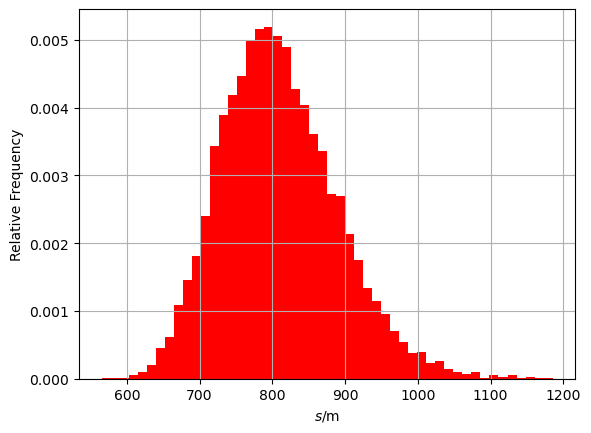

In [37]:
plt.xlabel('$s$/m')
plt.ylabel('Relative Frequency')
plt.grid()
plt.hist(slist, density = True, bins = 50, color = 'red')
plt.savefig('DistanceDensity.pdf', dpi = 600, bbox_inches = 'tight') 

### Finding braking distances in excess of 1000 m

In [40]:
sarray = np.array(slist)
scrit = 1000
n = len(sarray[sarray > scrit])
print(f'Exceeding {scrit} m: {n} realisations')
print(f'Probability of exceeding {scrit} m: {100*n/N} %')
print(f'Maximum braking distance_ {np.round(np.max(sarray))} m')

Exceeding 1000 m: 183 realisations
Probability of exceeding 1000 m: 1.83 %
Maximum braking distance_ 1185.0 m
